In [1]:
import theano
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from ple.games.pixelcopter import Pixelcopter
from ple import PLE
import pygame
import numpy as np
import time
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import datetime

# model = Sequential()
# model.add(Dense(20, input_dim=5, activation="relu"))
# model.add(Dense(10, activation="relu"))
# model.add(Dense(2, activation="linear"))
# adam = Adam(lr=0.0001)
# model.compile(loss='mse', optimizer=adam)

model = load_model("w_2018-08-15_19:18:42.299765.txt")

/Users/eddiewang/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


couldn't import doomish
Couldn't import doom


In [3]:
game = Pixelcopter(width=256, height=256)
p = PLE(game, fps=30, display_screen=False)

reward = 0.0
p.init()
#game.screen = pygame.display.set_mode(game.getScreenDims(), 0, 32)
#game.clock = pygame.time.Clock()
count = 0

epochs = 1000
rewards = np.zeros((1,epochs))[0]
gamma = 0.95 #since it may take several moves to goal, making gamma high
epsilon = 0.1
batchSize = 1000
buffer = 2000
replay = []
i = 0
h = 0

In [5]:
for i in range(epochs):
    
    p.reset_game()
    
    while (not p.game_over()):
        state = game.getGameState()
        stateLst = np.array([[state[k] for k in state]])
        qval = model.predict(stateLst)
        if (random.random() < epsilon):
            action = np.random.randint(0,2)
            print("here ", action)
        else:
            action = np.argmax(qval)
            
        actionList = p.getActionSet()
        reward = p.act(actionList[action])

        newState = game.getGameState()
        newStateLst = np.array([[newState[k] for k in state]])

        if (len(replay) < buffer):
            replay.append((stateLst, action, reward, newStateLst))
        else:
            if h < buffer-1:
                h += 1
            else:
                h = 0
            replay[h] = (stateLst, action, reward, newStateLst)
            minibatch = random.sample(replay, batchSize)
            X_train = np.empty((0,5))
            y_train = np.empty((0,2))

            for memory in minibatch:
                old_state, action, reward, new_state = memory
                oldQ = model.predict(old_state)
                newQ = model.predict(newStateLst)
                maxQ = np.max(newQ)

                if p.game_over():
                    update = reward
                else:
                    update = reward + (gamma * maxQ)
                y = np.copy(oldQ)
                y[0][action] = update
                X_train = np.append(X_train, old_state, axis=0)
                y_train = np.append(y_train, y, axis=0)

            model.fit(X_train, y_train, batch_size=batchSize)

        pygame.display.update()
        print(i)
        clear_output(wait=True)
    
    
    rewards[i] = p.score()
    i += 1
    if epsilon > 0.0001: #decrement epsilon over time
        epsilon -= (1/epochs)
    
    if i % 500 == 0:    
        f = "w_" + str(datetime.datetime.now()).replace(" ", "_") + ".txt"
        model.save(f)

70


KeyboardInterrupt: 

In [4]:
def testAgent(epochs):
    p.init()
    game.screen = pygame.display.set_mode(game.getScreenDims(), 0, 32)
    game.clock = pygame.time.Clock()
    i = 0
    while (i < epochs):
    
        p.reset_game()

        while (not p.game_over()):
            state = game.getGameState()
            stateLst = np.array([[state[k] for k in state]])
            qval = model.predict(stateLst)
            action = np.argmax(qval)
            actionList = p.getActionSet()
            reward = p.act(actionList[action])

            pygame.display.update()
        
        i += 1

testAgent(1000)

KeyboardInterrupt: 

In [ ]:
print(epsilon, i)

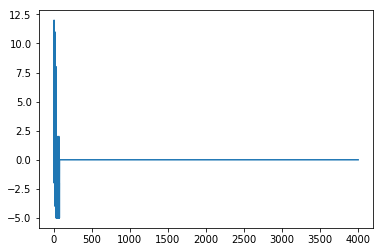

In [28]:
plt.plot(np.arange(epochs), rewards)
plt.show()

In [1]:
plt.scatter(np.arange(epochs), rewards)
plt.show()

NameError: name 'plt' is not defined

In [36]:
f = "w_" + str(datetime.datetime.now()).replace(" ", "_") + ".txt"
model.save(f)